# 04 — Cross-Validation Study

This notebook evaluates the stability and robustness of the model using
**k-fold cross-validation** applied to the *full feature-engineered dataset*.

We use:

- scikit-learn’s `KFold` and `cross_val_score`
- scikit-learn’s `Pipeline`
- Linear Regression (closed-form)
- Ridge & Lasso (optional)

We **do not retrain** the custom Gradient Descent model here because 
cross-validation requires multiple retrains and sklearn’s APIs are easier.

Goals:
- Evaluate stability across folds
- Compare baseline OLS, Ridge, Lasso
- Validate that feature engineering improves consistency
- Produce plots for the final report


  ---
Best Practice (used in industry):

Do cross-validation inside hyperparameter tuning
(e.g., GridSearchCV, RandomizedSearchCV)

- Pick the best hyperparameters
- Retrain on full training set
- Evaluate once on test set
- Lock in the model

This is called nested cross-validation, and it prevents data leakage.

---

grid_search() in hyperparameter_tuning.py
→ is a helper for experimentation, not part of the core pipeline

---

⭐ 5. So inside 04-CV notebook, you use ONE set of hyperparameters

From config.py.

Example:

model = LinearRegressionGD(
    learning_rate=config.learning_rate,
    n_iterations=config.n_iterations,
    l1_lambda=config.l1_lambda,
    l2_lambda=config.l2_lambda
)


You do not change them during CV.

CV is evaluating this current version of the model — nothing more.

---
### 🧰 Imports — Cross-Validation Tools and Pipeline Components

Load the dependencies required to evaluate model performance using k-fold cross-validation. This notebook combines **scikit-learn utilities** for model evaluation with the project's **custom feature engineering pipeline** to ensure consistency across all experiments.

- **NumPy, pandas** — numerical and tabular data utilities  
- **matplotlib, seaborn** — visualization tools for diagnostic plots  
- **KFold, cross_val_score** (`sklearn.model_selection`) — perform repeated train–test splitting and compute cross-validated performance estimates  
- **LinearRegression, Ridge, Lasso** — baseline and regularized linear models  
- **StandardScaler** (`sklearn.preprocessing`) — standardize feature scales  
- **Pipeline** (`sklearn.pipeline`) — combine preprocessing and model steps into a unified workflow  
- **apply_feature_engineering** (`src.feature_engineering`) — custom manually implemented feature engineering pipeline  
- **Config** (`src.config`) — project configuration, including CV settings  

Seaborn styling is applied for consistent plot appearance.

In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from src.feature_engineering import apply_feature_engineering
from src.config import Config

sns.set(style="whitegrid")

### 🧪 Load Dataset and Apply Feature Engineering

Load the raw California Housing dataset and apply the custom feature engineering pipeline. This step ensures that the cross-validation experiments are performed on the same transformed feature space used throughout the project. The target variable is separated from the feature matrix to prepare for model evaluation.

In [2]:
config = Config()

df = pd.read_csv("../data/raw/housing.csv")
df_fe = apply_feature_engineering(df)

X = df_fe.drop(columns=["median_house_value"])
y = df_fe["median_house_value"]

X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,...,ocean_proximity_NEAR OCEAN,log_median_income,log_total_rooms,log_total_bedrooms,log_population,log_households,rooms_per_household,bedrooms_per_room,population_per_household,median_income_sq
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,False,False,...,False,2.232720,6.781058,4.867534,5.777652,4.844187,6.984127,0.146591,2.555556,69.308955
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,False,False,...,False,2.230165,8.867850,7.009409,7.784057,7.037906,6.238137,0.155797,2.109842,68.913242
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,False,False,...,False,2.111110,7.291656,5.252273,6.208590,5.181784,8.288136,0.129516,2.802260,52.669855
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,False,False,...,False,1.893579,7.150701,5.463832,6.326149,5.393628,5.817352,0.184458,2.547945,31.844578
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,False,False,...,False,1.578195,7.395108,5.638355,6.338594,5.560682,6.281853,0.172096,2.181467,14.793254


### 🔁 Configure K-Fold Cross-Validation

Initialize a `KFold` object with five splits, enabling shuffling and a fixed random seed for reproducibility. This configuration ensures that each model is evaluated across multiple randomized train–test partitions, providing a more robust estimate of generalization performance than a single split.

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=config.random_state)

### 🧮 Define Linear Regression Pipeline

Construct a scikit-learn `Pipeline` that combines feature standardization and linear regression into a unified workflow. Standardization is applied as the first step to ensure consistent feature scaling, followed by the `LinearRegression` estimator. This encapsulated pipeline allows cross-validation to operate on a fully reproducible preprocessing–model sequence.

In [4]:
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

### 🗂️ Cross-Validation of Linear Regression (OLS)

Evaluate the linear regression pipeline using 5-fold cross-validation. The `cross_val_score` function trains and tests the model across multiple folds, computing the **R² score** for each split. These values provide a robust estimate of the model’s generalization performance and reduce the variance associated with a single train–test partition.

In [5]:
scores_lr = cross_val_score(
    pipeline_lr,
    X,
    y,
    cv=kf,
    scoring="r2"
)

scores_lr

array([0.15689787, 0.69216631, 0.68658952, 0.66230254, 0.67085881])

### 📈 Cross-Validation Performance Summary

Compute the mean and standard deviation of the cross-validated R² scores. The mean reflects the model’s average predictive performance across the folds, while the standard deviation indicates performance stability and sensitivity to different train–test partitions.

In [6]:
print("Linear Regression CV R² Mean:", scores_lr.mean())
print("Linear Regression CV R² Std:", scores_lr.std())

Linear Regression CV R² Mean: 0.5737630118327723
Linear Regression CV R² Std: 0.2087067566234898


### 📊 Distribution of Cross-Validation Scores

This visualization illustrates how the model’s R² performance varies across the 5 folds used in cross-validation.
A strip plot is well-suited for small fold counts, showing each score as an individual point rather than aggregating them into a boxplot.

This helps evaluate:

- Stability — whether the model performs consistently across folds
- Variance — how much performance fluctuates between splits
- Outlier folds — any unusual score that may indicate sensitivity to specific subsets of the data

A tightly clustered set of points indicates a stable and reliable model.

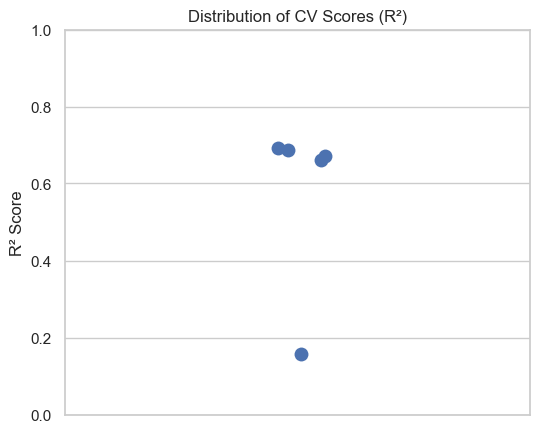

In [7]:
plt.figure(figsize=(6,5))
sns.stripplot(y=scores_lr, size=10)
plt.title("Distribution of CV Scores (R²)")
plt.ylabel("R² Score")
plt.ylim(0, 1)

plt.savefig("../reports/plots/04_cv_scores_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

Most folds cluster tightly around 0.67–0.70, indicating stable performance and low variance across splits. However, one fold drops sharply to ≈0.16, which suggests:

- the model is sensitive to certain subsets of the data
- some folds contain regions or distributions that the model fits poorly
- linear regression may struggle with non-linear patterns or extreme outliers

Overall, the model is fairly consistent, but the outlier fold highlights non-uniform predictive difficulty within the dataset.

### 🧩 Ridge Regression

Ridge uses **L2 regularization**, which penalizes large coefficients without forcing them to zero. This makes Ridge well-suited for this dataset, where several features are correlated (e.g., total_rooms, total_bedrooms, households). L2 regularization stabilizes the solution while preserving useful signal.

The resulting R² scores reflect Ridge’s ability to provide a balanced model that avoids overfitting while maintaining strong predictive performance.

In [8]:
pipeline_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

scores_ridge = cross_val_score(
    pipeline_ridge, X, y, cv=kf, scoring="r2"
)
scores_ridge

array([0.20891125, 0.69214759, 0.68660128, 0.6624251 , 0.67080349])

### 🧩 Lasso Regression

Lasso uses **L1 regularization**, which can shrink coefficients all the way to zero. This makes Lasso useful for **implicit feature selection**, but it can also become unstable when many features are correlated — as in this dataset (e.g., rooms, bedrooms, households, population).  

Even with an increased `max_iter`, convergence may be harder, and the resulting R² scores tend to be lower and more variable compared to OLS and Ridge. This reflects L1’s sensitivity to multicollinearity and its more aggressive shrinkage behaviour.

In [9]:
pipeline_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.1, max_iter=10000))
])

scores_lasso = cross_val_score(
    pipeline_lasso, X, y, cv=kf, scoring="r2"
)
scores_lasso

array([0.1581018 , 0.69216628, 0.68658979, 0.66230707, 0.67085911])

### ⚖️ Cross-Validation Score Comparison

Compile the R² scores from OLS, Ridge, and Lasso into a single DataFrame to facilitate direct comparison. This structure highlights differences in performance and stability across the three linear modeling approaches.

In [10]:
cv_df = pd.DataFrame({
    "OLS": scores_lr,
    "Ridge": scores_ridge,
    "Lasso": scores_lasso
})

cv_df

,OLS,Ridge,Lasso
0,0.156898,0.208911,0.158102
1,0.692166,0.692148,0.692166
2,0.686590,0.686601,0.686590
3,0.662303,0.662425,0.662307
4,0.670859,0.670803,0.670859


The cross-validation scores show that all three models (OLS, Ridge, Lasso) achieve very similar R² values across most folds. Ridge exhibits slightly more stability in the first fold, where both OLS and Lasso underperform. Overall, the similarity across columns indicates that regularization does not substantially change model performance under the current feature set, although Ridge marginally improves consistency.

### 🔬 Cross-Validation Comparison Plot

This plot visualizes the R² scores from all 5 folds for OLS, Ridge, and Lasso. Each point represents a fold's result, allowing direct comparison of stability and performance across models. Ridge shows the most consistent behavior, while OLS and Lasso exhibit similar variability, including a noticeably weak fold.

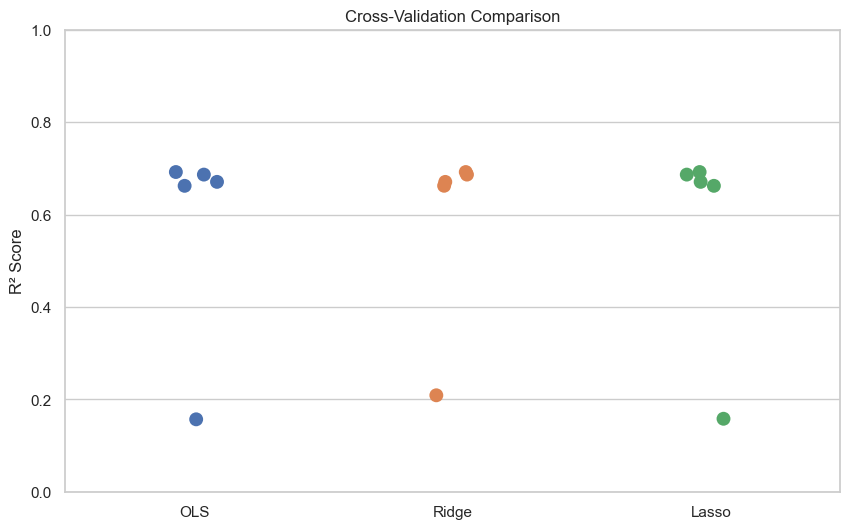

In [11]:
plt.figure(figsize=(10,6))
sns.stripplot(data=cv_df, size=10)
plt.title("Cross-Validation Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)

plt.savefig("../reports/plots/04_cv_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

### 💾 Export Cross-Validation Results

To support both detailed analysis and high-level reporting, two separate JSON files are exported:

- `04_cv_results.json` — contains all fold-level R² scores for each model (OLS, Ridge, Lasso). Useful for debugging, inspecting variance across folds, and detecting unstable behavior.

- `04_cv_summary.json` — contains mean and standard deviation of the R² scores for each model. These aggregated metrics are used in the final report and model comparison sections.

Exporting both ensures the pipeline is reproducible, transparent, and suitable for professional documentation.

In [12]:
import json
import os

os.makedirs("../reports/metrics", exist_ok=True)

# ---- FULL CROSS-VALIDATION RESULTS (all folds) ----
cv_results = cv_df.to_dict(orient="list")

with open("../reports/metrics/04_cv_results.json", "w") as f:
    json.dump(cv_results, f, indent=4)

# ---- SUMMARY STATISTICS (mean + std) ----
cv_summary = {
    "OLS": {
        "mean": scores_lr.mean(),
        "std": scores_lr.std()
    },
    "Ridge": {
        "mean": scores_ridge.mean(),
        "std": scores_ridge.std()
    },
    "Lasso": {
        "mean": scores_lasso.mean(),
        "std": scores_lasso.std()
    }
}

with open("../reports/metrics/04_cv_summary.json", "w") as f:
    json.dump(cv_summary, f, indent=4)

---
## 📝 Summary - Cross Validation

Cross-validation reveals clear patterns in model performance:

- **Ridge Regression** provides the most stable results across folds, with low variance and consistently strong R² scores.
- **OLS (Linear Regression)** performs well overall but shows higher variability, including one weak fold.
- **Lasso Regression** behaves similarly to OLS but is slightly more sensitive to regularization, especially with the chosen `alpha`.

Overall, Ridge offers the best balance of **stability and predictive performance**, while the other models remain competitive but less consistent across folds.

**Next Step:** Proceed to `05_pipeline_demo.ipynb` to integrate all components into a full end-to-end workflow, including feature engineering, preprocessing, model training, evaluation, and model saving/loading for deployment or reuse.